In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats as sps

import catboost
import shap

sns.set_style('whitegrid')
shap.initjs()

In [3]:
data = pd.read_feather('../data/train_dataset.fth')
vacs = pd.read_feather('../data/vac.no_desc.fth')
vacs['compensation.from'] = vacs['compensation.from'].fillna(0.)
vacs['compensation.to'] = vacs['compensation.to'].fillna(vacs['compensation.from'])
vacs = vacs.fillna('null')
data = data.merge(vacs.rename(columns={'vacancy_id': 'vac'}), on='vac')

data.head(2)

,vac,action_1,action_2,action_3,sessions_back_first,sessions_back_last,target,user_id,session_id,session_end,name,company.id,compensation.from,compensation.to,compensation.currencyCode,area.id,area.regionId,employment,workSchedule,workExperience
0,v_499393,0,1,0,1,1,1.0,u_100000,s_24856720,2023-11-07 11:19:28.175,IOS разработчик,c_13891,150000.0,250000.0,RUR,a_1756,ar_41,full,fullDay,between1And3
1,v_499393,1,1,0,1,1,0.0,u_1117943,s_5612240,2023-11-09 18:01:52.984,IOS разработчик,c_13891,150000.0,250000.0,RUR,a_1756,ar_41,full,fullDay,between1And3


In [4]:
data.shape[0]

636270

To output multiple subplots, the figure containing the passed axes is being cleared.


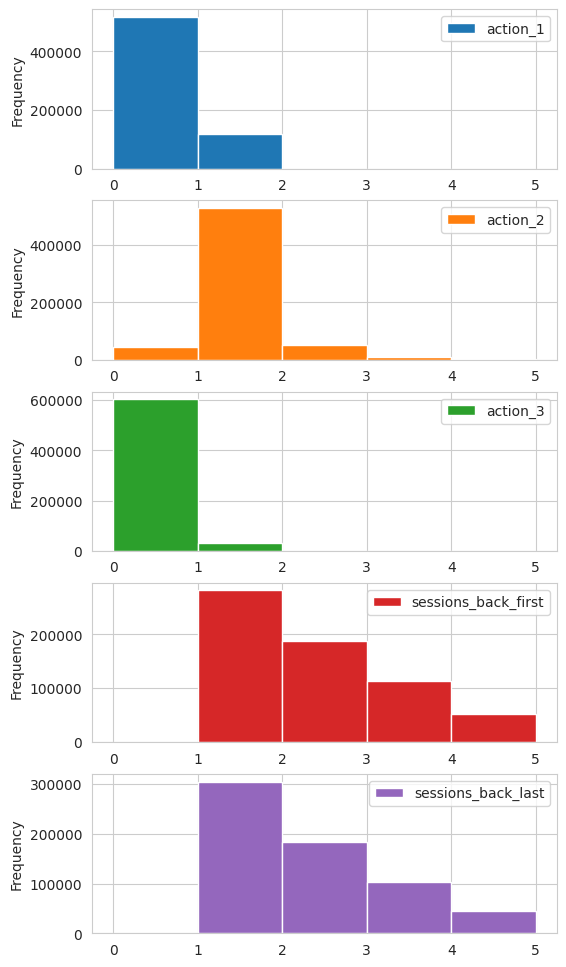

In [5]:
plt.figure(figsize=(6, 12))
data[[
    'action_1',
    'action_2',
    'action_3',
    'sessions_back_first',
    'sessions_back_last',
]].plot(subplots=True, kind='hist', range=(0, 5), bins=5, ax=plt.gca())
plt.show()

In [6]:
(data['sessions_back_first'] == data['sessions_back_last']).mean()

0.9438147327392459

## Train catboost

In [7]:
float_features = [
    'action_1',
    'action_2',
    'action_3',
    # 'sessions_back_first',
    'sessions_back_last',
    'compensation.from',
    'compensation.to',
]

cat_features = [
    'vac',
    'name',
    'company.id',
    'compensation.currencyCode',
    'area.id',
    'area.regionId',
    'employment',
    'workSchedule',
    'workExperience',
]

ranker_features = float_features + cat_features

In [8]:
train_sz = int(data.shape[0] * 0.7)

catboost_data = data.copy()
catboost_data[cat_features] = catboost_data[cat_features].astype(str)

train = data.iloc[:train_sz].sort_values('user_id')
test = data.iloc[train_sz:].sort_values('user_id')

print(f'Split sizes: train - {train.shape[0]}, test - {test.shape[0]}')

Split sizes: train - 445389, test - 190881


In [9]:
data.head(2)

,vac,action_1,action_2,action_3,sessions_back_first,sessions_back_last,target,user_id,session_id,session_end,name,company.id,compensation.from,compensation.to,compensation.currencyCode,area.id,area.regionId,employment,workSchedule,workExperience
0,v_499393,0,1,0,1,1,1.0,u_100000,s_24856720,2023-11-07 11:19:28.175,IOS разработчик,c_13891,150000.0,250000.0,RUR,a_1756,ar_41,full,fullDay,between1And3
1,v_499393,1,1,0,1,1,0.0,u_1117943,s_5612240,2023-11-09 18:01:52.984,IOS разработчик,c_13891,150000.0,250000.0,RUR,a_1756,ar_41,full,fullDay,between1And3


In [10]:
train_pool = catboost.Pool(
    data=train[ranker_features],
    label=train['target'],
    cat_features=cat_features,
    group_id=train['user_id'],
)
test_pool = catboost.Pool(
    data=test[ranker_features],
    label=test['target'],
    cat_features=cat_features,
    group_id=test['user_id'],
)

model = catboost.CatBoostRanker(
    n_estimators=1000,
    eval_metric='NDCG',
)

model.fit(
    X=train_pool,
    eval_set=test_pool,
    verbose=10,
    early_stopping_rounds=100,
    plot=True,
    
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Groupwise loss function. OneHotMaxSize set to 10
0:	test: 0.9789211	best: 0.9789211 (0)	total: 783ms	remaining: 13m 2s
10:	test: 0.9806953	best: 0.9806953 (10)	total: 4.1s	remaining: 6m 9s
20:	test: 0.9819226	best: 0.9819226 (20)	total: 6.86s	remaining: 5m 19s
30:	test: 0.9827700	best: 0.9827700 (30)	total: 10.9s	remaining: 5m 39s
40:	test: 0.9830255	best: 0.9830301 (38)	total: 14.5s	remaining: 5m 40s
50:	test: 0.9830673	best: 0.9830711 (49)	total: 18s	remaining: 5m 35s
60:	test: 0.9831903	best: 0.9832123 (56)	total: 22s	remaining: 5m 38s
70:	test: 0.9838763	best: 0.9838763 (70)	total: 25.7s	remaining: 5m 35s
80:	test: 0.9839884	best: 0.9839884 (80)	total: 29.5s	remaining: 5m 34s
90:	test: 0.9841346	best: 0.9841346 (90)	total: 33.4s	remaining: 5m 34s
100:	test: 0.9842097	best: 0.9842097 (100)	total: 36.5s	remaining: 5m 25s
110:	test: 0.9841708	best: 0.9842224 (101)	total: 39.7s	remaining: 5m 18s
120:	test: 0.9841680	best: 0.9842224 (101)	total: 42.9s	remaining: 5m 11s
130:	test: 0.9841

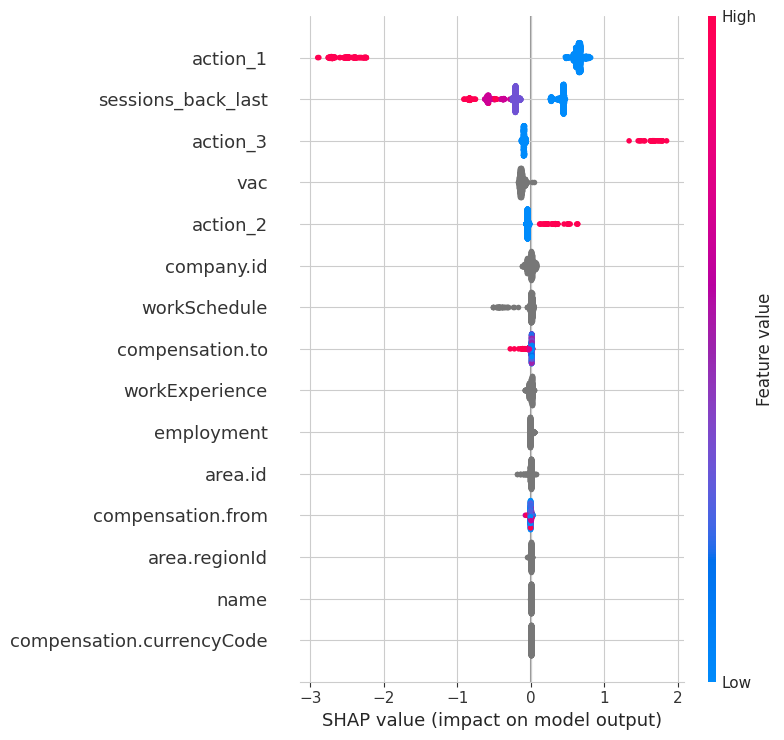

In [11]:
sample = test.sample(n=1000).reset_index(drop=True)

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(sample[ranker_features])

shap.summary_plot(
    shap_values,
    feature_names=ranker_features,
    features=sample[ranker_features],
)

In [2]:
import shap
help(shap.summary_plot)

Help on function summary_legacy in module shap.plots._beeswarm:

summary_legacy(shap_values, features=None, feature_names=None, max_display=None, plot_type=None, color=None, axis_color='#333333', title=None, alpha=1, show=True, sort=True, color_bar=True, plot_size='auto', layered_violin_max_num_bins=20, class_names=None, class_inds=None, color_bar_label='Feature value', cmap=<matplotlib.colors.LinearSegmentedColormap object at 0x7fc57e8e8cd0>, show_values_in_legend=False, auto_size_plot=None, use_log_scale=False)
    Create a SHAP beeswarm plot, colored by feature values when they are provided.
    
    Parameters
    ----------
    shap_values : numpy.array
        For single output explanations this is a matrix of SHAP values (# samples x # features).
        For multi-output explanations this is a list of such matrices of SHAP values.
    
    features : numpy.array or pandas.DataFrame or list
        Matrix of feature values (# samples x # features) or a feature_names list as short